# This Script Tests the QAT 1 ad QAT 2 Tranformer using the Glove embedding for the input data

In [1]:
import pandas as pd
import numpy as np
import torchtext
import torch
from torch import nn
import torch.nn.functional as F
import spacy
import pickle
nlp = spacy.load('en')
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/Data2')

# Preprocessing 
## making weight matrices and creating embeddings

In [ ]:
def load_json(path):
    '''
    Loads the JSON file of the Squad dataset.
    Returns the json object of the dataset.
    '''
    with open(path, 'r') as f:
        data = json.load(f)
        
    print("Length of data: ", len(data['data']))
    print("Data Keys: ", data['data'][0].keys())
    print("Title: ", data['data'][0]['title'])
    
    return data




def parse_data(data:dict)->list:
    '''
    Parses the JSON file of Squad dataset by looping through the
    keys and values and returns a list of dictionaries with
    context, query and label triplets being the keys of each dict.
    '''
    data = data['data']
    qa_list = []

    for paragraphs in data:

        for para in paragraphs['paragraphs']:
            context = para['context']

            for qa in para['qas']:
                
                id = qa['id']
                question = qa['question']
                
                for ans in qa['answers']:
                    answer = ans['text']
                    ans_start = ans['answer_start']
                    ans_end = ans_start + len(answer)
                    
                    qa_dict = {}
                    qa_dict['id'] = id
                    qa_dict['context'] = context
                    qa_dict['question'] = question
                    qa_dict['label'] = [ans_start, ans_end]

                    qa_dict['answer'] = answer
                    qa_list.append(qa_dict)    

    
    return qa_list



def filter_large_examples(df):
    '''
    Returns ids of examples where context lengths, query lengths and answer lengths are
    above a particular threshold. These ids can then be dropped from the dataframe. 
    This is explicitly mentioned in QANet but can be done for other models as well.
    '''
    
    ctx_lens = []
    query_lens = []
    ans_lens = []
    for index, row in df.iterrows():
        ctx_tokens = [w.text for w in nlp(row.context, disable=['parser','ner','tagger'])]
        if len(ctx_tokens)>400:
            ctx_lens.append(row.name)

        query_tokens = [w.text for w in nlp(row.question, disable=['parser','tagger','ner'])]
        if len(query_tokens)>50:
            query_lens.append(row.name)

        ans_tokens = [w.text for w in nlp(row.answer, disable=['parser','tagger','ner'])]
        if len(ans_tokens)>30:
            ans_lens.append(row.name)

        assert row.name == index
    
    return set(ans_lens + ctx_lens + query_lens)


def gather_text_for_vocab(dfs:list):
    '''
    Gathers text from contexts and questions to build a vocabulary.
    
    :param dfs: list of dataframes of SQUAD dataset.
    :returns: list of contexts and questions
    '''
    
    text = []
    total = 0
    for df in dfs:
        unique_contexts = list(df.passage.unique())
        unique_questions = list(df.question.unique())
        total += df.passage.nunique() + df.question.nunique()
        text.extend(unique_contexts + unique_questions)
    
    assert len(text) == total
    
    return text




def build_word_vocab(vocab_text):
    '''
    Builds a word-level vocabulary from the given text.
    
    :param list vocab_text: list of contexts and questions
    :returns 
        dict word2idx: word to index mapping of words
        dict idx2word: integer to word mapping
        list word_vocab: list of words sorted by frequency
    '''
    
    
    words = []
    for sent in vocab_text:
        for word in nlp(sent, disable=['parser','tagger','ner']):
            words.append(word.text)

    word_counter = Counter(words)
    word_vocab = sorted(word_counter, key=word_counter.get, reverse=True)
    print(f"raw-vocab: {len(word_vocab)}")
    word_vocab.insert(0, '<unk>')
    word_vocab.insert(1, '<pad>')
    print(f"vocab-length: {len(word_vocab)}")
    word2idx = {word:idx for idx, word in enumerate(word_vocab)}
    print(f"word2idx-length: {len(word2idx)}")
    idx2word = {v:k for k,v in word2idx.items()}
    
    
    return word2idx, idx2word, word_vocab





def build_char_vocab(vocab_text):
    '''
    Builds a character-level vocabulary from the given text.
    
    :param list vocab_text: list of contexts and questions
    :returns 
        dict char2idx: character to index mapping of words
        list char_vocab: list of characters sorted by frequency
    '''
    
    chars = []
    for sent in vocab_text:
        for ch in sent:
            chars.append(ch)

    char_counter = Counter(chars)
    char_vocab = sorted(char_counter, key=char_counter.get, reverse=True)
    print(f"raw-char-vocab: {len(char_vocab)}")
    high_freq_char = [char for char, count in char_counter.items() if count>=20]
    char_vocab = list(set(char_vocab).intersection(set(high_freq_char)))
    print(f"char-vocab-intersect: {len(char_vocab)}")
    char_vocab.insert(0,'<unk>')
    char_vocab.insert(1,'<pad>')
    char2idx = {char:idx for idx, char in enumerate(char_vocab)}
    print(f"char2idx-length: {len(char2idx)}")
    
    return char2idx, char_vocab



def context_to_ids(text, word2idx):
    '''
    Converts context text to their respective ids by mapping each word
    using word2idx. Input text is tokenized using spacy tokenizer first.
    
    :param str text: context text to be converted
    :param dict word2idx: word to id mapping

    :returns list context_ids: list of mapped ids
    
    :raises assertion error: sanity check
    
    '''
    
    context_tokens = [w.text for w in nlp(text, disable=['parser','tagger','ner'])]
    context_ids = [word2idx[word] for word in context_tokens]
    
    assert len(context_ids) == len(context_tokens)
    return context_ids



    
def question_to_ids(text, word2idx):
    '''
    Converts question text to their respective ids by mapping each word
    using word2idx. Input text is tokenized using spacy tokenizer first.
    
    :param str text: question text to be converted
    :param dict word2idx: word to id mapping
    :returns list context_ids: list of mapped ids
    
    :raises assertion error: sanity check
    
    '''
    
    question_tokens = [w.text for w in nlp(text, disable=['parser','tagger','ner'])]
    question_ids = [word2idx[word] for word in question_tokens]
    
    assert len(question_ids) == len(question_tokens)
    return question_ids
    


    
def test_indices(df, idx2word):
    '''
    Performs the tests mentioned above. This method also gets the start and end of the answers
    with respect to the context_ids for each example.
    
    :param dataframe df: SQUAD df
    :param dict idx2word: inverse mapping of token ids to words
    :returns
        list start_value_error: example idx where the start idx is not found in the start spans
                                of the text
        list end_value_error: example idx where the end idx is not found in the end spans
                              of the text
        list assert_error: examples that fail assertion errors. A majority are due to the above errors
        
    '''

    start_value_error = []
    end_value_error = []
    assert_error = []
    for index, row in df.iterrows():
        
        context_span  = [(word.idx, word.idx + len(word.text)) 
                         for word in nlp(row['passage'], disable=['parser','tagger','ner'])]

        starts, ends = zip(*context_span)

        answer_start, answer_end = row['label']

        try:
            start_idx = starts.index(answer_start)
        except:
            start_value_error.append(index)
        try:
            end_idx  = ends.index(answer_end)
        except:
            end_value_error.append(index)


    return start_value_error, end_value_error, assert_error



def get_error_indices(df, idx2word):
    
    start_value_error, end_value_error, assert_error = test_indices(df, idx2word)
    err_idx = start_value_error + end_value_error + assert_error
    err_idx = set(err_idx)
    print(f"Number of error indices: {len(err_idx)}")
    
    return err_idx



def index_answer(row, idx2word):
    '''
    Takes in a row of the dataframe or one training example and
    returns a tuple of start and end positions of answer by calculating 
    spans.
    '''
    
    context_span = [(word.idx, word.idx + len(word.text)) for word in nlp(row.context, disable=['parser','tagger','ner'])]
    starts, ends = zip(*context_span)
    
    answer_start, answer_end = row.label
    start_idx = starts.index(answer_start)
 
    end_idx  = ends.index(answer_end)
    
    ans_toks = [w.text for w in nlp(row.answer,disable=['parser','tagger','ner'])]
    ans_start = ans_toks[0]
    ans_end = ans_toks[-1]
    assert idx2word[row.context_ids[start_idx]] == ans_start
    assert idx2word[row.context_ids[end_idx]] == ans_end
    
    return [start_idx, end_idx]

In [ ]:
train_df  = pd.read_json("train.jsonl", lines=True)
valid_df  = pd.read_json("dev.jsonl", lines=True)
train_df.columns,valid_df.columns

(Index(['question', 'title', 'answer', 'passage'], dtype='object'),
 Index(['question', 'title', 'answer', 'passage'], dtype='object'))

In [ ]:
def normalize_spaces(text):
    '''
    Removes extra white spaces from the context.
    '''
    text = re.sub(r'\s', ' ', text)
    return text

train_df.passage = train_df.passage.apply(normalize_spaces)
valid_df.passage = valid_df.passage.apply(normalize_spaces)

In [ ]:
vocab_text = gather_text_for_vocab([train_df, valid_df, test_df])
print("Number of sentences in dataset: ", len(vocab_text))

Number of sentences in dataset:  29730


In [ ]:
%time word2idx, idx2word, word_vocab = build_word_vocab(vocab_text)

raw-vocab: 67984
vocab-length: 67986
word2idx-length: 67986
CPU times: user 17 s, sys: 235 ms, total: 17.3 s
Wall time: 17.3 s


In [ ]:
%time train_df['context_ids'] = train_df.passage.apply(context_to_ids, word2idx=word2idx)
%time valid_df['context_ids'] = valid_df.passage.apply(context_to_ids, word2idx=word2idx)

%time train_df['question_ids'] = train_df.question.apply(question_to_ids,  word2idx=word2idx)
%time valid_df['question_ids'] = valid_df.question.apply(question_to_ids,  word2idx=word2idx)

CPU times: user 9 s, sys: 53.5 ms, total: 9.05 s
Wall time: 9.06 s
CPU times: user 3.29 s, sys: 11.7 ms, total: 3.3 s
Wall time: 3.3 s
CPU times: user 1.4 s, sys: 13.7 ms, total: 1.41 s
Wall time: 1.41 s
CPU times: user 490 ms, sys: 5.3 ms, total: 495 ms
Wall time: 494 ms


In [ ]:
import pickle
with open('drqastoi.pickle','wb') as handle:
    pickle.dump(word2idx, handle)
    
train_df.to_pickle('drqatrain.pkl')
valid_df.to_pickle('drqavalid.pkl')

In [ ]:
def create_glove_matrix():
    '''
    Parses the glove word vectors text file and returns a dictionary with the words as
    keys and their respective pretrained word vectors as values.

    '''
    glove_dict = {}
    with open("glove.42B.300d.txt", "r", encoding="utf-8") as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            glove_dict[word] = vector

    f.close()
    
    return glove_dict

In [ ]:
glove_dict = create_glove_matrix()

In [ ]:
def create_word_embedding(glove_dict, word_vocab):
    '''
    Creates a weight matrix of the words that are common in the GloVe vocab and
    the dataset's vocab. Initializes OOV words with a zero vector.
    '''
    weights_matrix = np.zeros((len(word_vocab), 300))
    words_found = 0
    for i, word in enumerate(word_vocab):
        try:
            weights_matrix[i] = glove_dict[word]
            words_found += 1
        except:
            pass
    return weights_matrix, words_found

In [ ]:
weights_matrix, words_found = create_word_embedding(glove_dict, word_vocab)

In [ ]:
np.save('drqaglove_vt.npy',weights_matrix)

In [ ]:
with open('idx2word.pickle','wb') as handle:
    pickle.dump(idx2word, handle)

In [4]:
class SquadDataset:
    '''
    -Divides the dataframe in batches.
    -Pads the contexts and questions dynamically for each batch by padding 
     the examples to the maximum-length sequence in that batch.
    -Calculates masks for context and question.
    -Calculates spans for contexts.
    '''
    
    def __init__(self, data, batch_size, max_context_len, max_question_len):
        
        self.batch_size = batch_size
        data = [data[i:i+self.batch_size] for i in range(0, len(data), self.batch_size)]
        self.data = data
        self.max_context_len = max_context_len
        self.max_question_len = max_question_len
    
    def get_span(self, text):
        
        text = nlp(text, disable=['parser','tagger','ner'])
        span = [(w.idx, w.idx+len(w.text)) for w in text]

        return span

    def __len__(self):
        return len(self.data)
    
    def __iter__(self):
        '''
        Creates batches of data and yields them.
        
        Each yield comprises of:
        :padded_context: padded tensor of contexts for each batch 
        :padded_question: padded tensor of questions for each batch 
        :context_mask & question_mask: zero-mask for question and context
        :label: start and end index wrt context_ids
        :context_text,answer_text: used while validation to calculate metrics
        :context_spans: spans of context text
        :ids: question_ids used in evaluation
        '''
        
        for batch in self.data:
                            
            spans = []
            context_text = []
            answer_text = []
            
            padded_context = torch.LongTensor(len(batch), self.max_context_len).fill_(1)
            
            # for ctx in batch.context:
            #     context_text.append(ctx)
            #     spans.append(self.get_span(ctx))
            
            for ans in batch.answer:
                answer_text.append(ans)
                
            for i, ctx in enumerate(batch.context_ids):
                padded_context[i, :len(ctx)] = torch.LongTensor(ctx)
            
            padded_question = torch.LongTensor(len(batch), self.max_question_len).fill_(1)
            
            for i, ques in enumerate(batch.question_ids):
                padded_question[i,: len(ques)] = torch.LongTensor(ques)
                
            
            # label = torch.LongTensor(list(batch.label_idx))
            context_mask = torch.eq(padded_context, 1)
            question_mask = torch.eq(padded_question, 1)
            answer_text = torch.as_tensor(answer_text).long()
            context_text = torch.as_tensor(context_text)
            # ids = list(batch.id)  
            
            yield (padded_context, padded_question, context_mask, 
                   question_mask, answer_text, context_text)


In [5]:
train_df = pd.read_pickle('drqatrain.pkl')
valid_df = pd.read_pickle('drqavalid.pkl')
weights_matrix = np.load("drqaglove_vt.npy")
with open("drqastoi.pickle","rb") as fle:
  word2idx = pickle.load(fle)

In [6]:
max_passage_len = train_df['context_ids'].apply(lambda x: len(x)).max()
max_passage_len = max(max_passage_len, valid_df['context_ids'].apply(lambda x: len(x)).max())
max_question_len = train_df['question_ids'].apply(lambda x: len(x)).max()
max_question_len = max(max_question_len, valid_df['question_ids'].apply(lambda x: len(x)).max())
print(max_passage_len, max_question_len)

967 21


In [7]:
train_df = train_df.iloc[:4096]
test_df = valid_df.iloc[256:512]
valid_df = valid_df.iloc[:256]
test_df.shape

(256, 6)

In [8]:
train_dataset = SquadDataset(train_df, 16, max_passage_len, max_question_len)
len(train_dataset)

256

In [9]:
valid_dataset = SquadDataset(valid_df, 16, max_passage_len, max_question_len)
test_dataset = SquadDataset(test_df, 16, max_passage_len, max_question_len)
print(test_df.shape)

(256, 6)


In [10]:
a = next(iter(train_dataset))

In [11]:
a[0].shape, a[1].shape, a[2].shape, a[3].shape, a[4].shape

(torch.Size([16, 967]),
 torch.Size([16, 21]),
 torch.Size([16, 967]),
 torch.Size([16, 21]),
 torch.Size([16]))

In [12]:
weights_matrix.shape

(67986, 300)

# QAT 2 Transformer Implemetation Starts Here

In [13]:
from torch import Tensor, nn, optim
from tqdm import tqdm
class QATransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int = 2,
        dim_model: int = 300,
        num_heads: int = 6,
        dim_feedforward: int = 2100,
        dropout: float = 0.,
        amalgamated_dim = 300,
    ):
        super().__init__()
        
        self.encoder_question = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim_model, 
                                                                                nhead=num_heads, 
                                                                                dim_feedforward=dim_feedforward, 
                                                                                dropout=dropout), 
                                                                                num_layers = num_encoder_layers)
        self.encoder_context = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim_model, 
                                                                                nhead=num_heads, 
                                                                                dim_feedforward=dim_feedforward, 
                                                                                dropout=dropout), 
                                                                                num_layers = num_encoder_layers)
        self.encoder_amalgamated = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim_model, 
                                                                        nhead=num_heads, 
                                                                        dim_feedforward=dim_feedforward, 
                                                                        dropout=dropout), 
                                                                        num_layers = num_encoder_layers)
        self.amalgmated_linear_2 = nn.Linear(dim_model, dim_feedforward)
        # self.attention = nn.MultiheadAttention(embed_dim= dim_feedforward,
        #                                        num_heads = num_heads,
        #                                        dropout=dropout,
        #                                        batch_first=True)

        self.linear_1 = nn.Linear(dim_feedforward, dim_feedforward)
        self.linear_2 = nn.Linear(amalgamated_dim*dim_feedforward, 1)

    def forward(self, context: Tensor, question: Tensor) -> Tensor:
        # print(context.type(), question.type())
        # src = torch.hstack([context,  question])
        question = self.encoder_question(question)
        context = self.encoder_context(context)

        amalgamated_x = torch.hstack([context, question])
        amalgamated_x = self.encoder_amalgamated(amalgamated_x)
        # print(amalgamated_x.shape)
        amalgamated_x = torch.relu(self.amalgmated_linear_2(amalgamated_x))
        amalgamated_x = torch.relu(self.linear_1(amalgamated_x))
        amalgamated_x = amalgamated_x.flatten(1)
        amalgamated_x = self.linear_2(amalgamated_x)
        return torch.sigmoid(amalgamated_x).squeeze()

In [14]:
def create_embedding_matrix(row_df, word2idx, weights_matrix):
  context_matrix = []
  positional_encoding= []
  context_str= row_df["context"]

  question_str= row_df["question"]

  answer_str= row_df["answer"]
  context_word_index  = [word2idx[str(word)] for word in nlp(context_str, disable=['parser','tagger','ner'])]
  context_matrix = weights_matrix[context_word_index]
  question_word_index  = [word2idx[str(word)] for word in nlp(question_str, disable=['parser','tagger','ner'])]
  question_matrix = weights_matrix[question_word_index]
  answer_word_index  = [word2idx[str(word)] for word in nlp(answer_str, disable=['parser','tagger','ner'])]
  answer_matrix = weights_matrix[answer_word_index]
  return context_matrix, question_matrix, answer_matrix

# QAT 2 Tranformer Training

In [15]:
import copy
net = QATransformer(amalgamated_dim = max_passage_len+ max_question_len)
state_dict = None
if torch.cuda.is_available():
  net = net.to("cuda")
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-6)
criterion = nn.BCELoss()
if torch.cuda.is_available():
  criterion = criterion.to("cuda")
val_criterion = nn.BCELoss()
if torch.cuda.is_available():
  val_criterion = val_criterion.to("cuda")
loss_array = []
acc = []
valid_acc = []
epochs=20
batch_count = 0
val_loss = []
max_acc = -1
for epoch in tqdm(range(epochs)):
  running_loss = 0
  encodings_arr = []
  for batch in train_dataset:
    optimizer.zero_grad()
    context, question, context_mask, question_mask, label, ctx = batch

    contexts = torch.as_tensor(weights_matrix[context]).float()
    if torch.cuda.is_available():
      contexts = contexts.to("cuda")

    questions = torch.as_tensor(weights_matrix[question]).float()
    if torch.cuda.is_available():
      questions = questions.to("cuda")

    if torch.cuda.is_available():
      context_mask = context_mask.to("cuda")

    if torch.cuda.is_available():
      question_mask = question_mask.to("cuda")

    label = label.float()
    if torch.cuda.is_available():
      label = label.to("cuda")
    encodings_arr.append((contexts, questions, label))
    output = net(contexts, questions)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()*output.shape[0]
  loss_array.append(running_loss/train_df.shape[0])
  pred = []
  for contexts, questions, label in encodings_arr:
    output = net(contexts, questions)
    pred.extend((output > 0.5).float() == label)
  pred = torch.as_tensor(pred)
  if torch.cuda.is_available():
      pred = pred.to("cuda")
  curr_acc = pred.float().mean()
  acc.append(curr_acc.to("cpu").item())
  pred = []
  val_running_loss = 0
  for batch in valid_dataset:
      context, question, context_mask, question_mask, label, ctx = batch
      contexts = torch.as_tensor(weights_matrix[context]).float()
      if torch.cuda.is_available():
        contexts = contexts.to("cuda")
      questions = torch.as_tensor(weights_matrix[question]).float()
      if torch.cuda.is_available():
        questions = questions.to("cuda")
      if torch.cuda.is_available():
        context_mask = context_mask.to("cuda")
      if torch.cuda.is_available():
        question_mask = question_mask.to("cuda")
      label = label.float()
      if torch.cuda.is_available():
        label = label.to("cuda")
      encodings_arr.append((contexts, questions, label))
      output = net(contexts, questions)
      loss = val_criterion(output, label)
      val_running_loss+=loss.item()*output.shape[0]
      pred.extend((output > 0.5).float() == label)
  pred = torch.as_tensor(pred)
  val_loss.append(val_running_loss/valid_df.shape[0])
  if torch.cuda.is_available():
      pred = pred.to("cuda")
  curr_acc = pred.float().mean()
  valid_acc.append(curr_acc.to("cpu").item())
  if(acc[-1]*valid_acc[-1] > max_acc):
    net1 = copy.deepcopy(net)
    net1.to('cpu')
    max_acc = acc[-1]*valid_acc[-1]
  torch.cuda.empty_cache()
  print(acc[-1], loss_array[-1], valid_acc[-1],val_loss[-1])

  5%|▌         | 1/20 [04:04<1:17:32, 244.89s/it]

0.621826171875 0.6850586186628789 0.6328125 0.6556639187037945


 10%|█         | 2/20 [08:10<1:13:36, 245.34s/it]

0.630126953125 0.6443657330237329 0.6328125 0.650429068133235


 15%|█▌        | 3/20 [12:15<1:09:24, 244.96s/it]

0.703369140625 0.6008364892331883 0.6328125 0.6461510024964809


 20%|██        | 4/20 [16:20<1:05:20, 245.01s/it]

0.77099609375 0.555122681427747 0.64453125 0.6403500325977802


 25%|██▌       | 5/20 [20:23<1:01:07, 244.49s/it]

0.826416015625 0.5216416163020767 0.62890625 0.6393546275794506


 30%|███       | 6/20 [24:28<57:03, 244.52s/it]  

0.863525390625 0.453929758281447 0.640625 0.6424136646091938


 35%|███▌      | 7/20 [28:31<52:55, 244.24s/it]

0.8857421875 0.39403980324277654 0.625 0.6434557214379311


 40%|████      | 8/20 [32:36<48:51, 244.26s/it]

0.887451171875 0.3553341928636655 0.6328125 0.656835300847888


 45%|████▌     | 9/20 [36:39<44:44, 244.02s/it]

0.880859375 0.34237913839751855 0.64453125 0.6819338947534561


 50%|█████     | 10/20 [40:42<40:36, 243.62s/it]

0.932861328125 0.3229795071820263 0.64453125 0.6650033537298441


 55%|█████▌    | 11/20 [44:43<36:26, 242.90s/it]

0.946044921875 0.25970355613389984 0.640625 0.6801148969680071


 60%|██████    | 12/20 [48:46<32:23, 242.94s/it]

0.962890625 0.2094168055918999 0.63671875 0.6972866952419281


 65%|██████▌   | 13/20 [52:49<28:20, 242.93s/it]

0.970703125 0.16995293376385234 0.6484375 0.7161306049674749


 70%|███████   | 14/20 [56:54<24:20, 243.41s/it]

0.978271484375 0.1394529241078999 0.6640625 0.7268780767917633


 75%|███████▌  | 15/20 [1:00:57<20:16, 243.38s/it]

0.97021484375 0.11855238477437524 0.625 0.7608713041990995


 80%|████████  | 16/20 [1:05:00<16:12, 243.13s/it]

0.924560546875 0.11448349010606762 0.56640625 0.9058087207376957


 85%|████████▌ | 17/20 [1:09:03<12:09, 243.18s/it]

0.973388671875 0.12645492466981523 0.609375 0.810894712805748


 90%|█████████ | 18/20 [1:13:08<08:07, 243.75s/it]

0.9794921875 0.10663591075717704 0.63671875 0.8356941286474466


 95%|█████████▌| 19/20 [1:17:11<04:03, 243.55s/it]

0.96630859375 0.08845835137617541 0.6484375 1.071897441521287


100%|██████████| 20/20 [1:21:14<00:00, 243.71s/it]

0.98974609375 0.05254205704477499 0.65234375 1.1701487619429827


In [16]:
with open("Train_4096.pkl", "wb") as fle:
  pickle.dump(net,fle)

with open("Train_Loss_4096.pkl", "wb") as fle:
  pickle.dump(loss_array,fle)

with open("Train_Acc_4096.pkl", "wb") as fle:
  pickle.dump(acc,fle)

with open("Val_Loss_4096.pkl", "wb") as fle:
  pickle.dump(val_loss,fle)

with open("Val_Acc_4096.pkl", "wb") as fle:
  pickle.dump(valid_acc,fle)

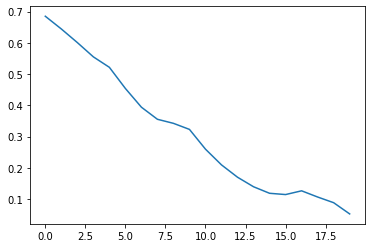

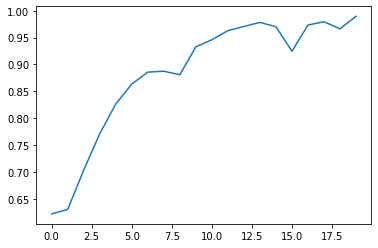

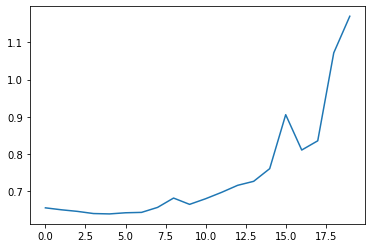

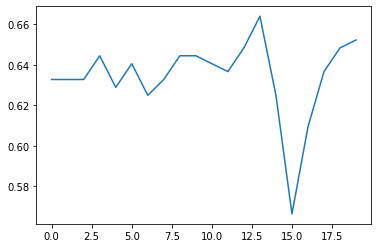

In [17]:
import matplotlib.pyplot as plt
plt.plot(loss_array)
plt.figure()
plt.plot(acc)
plt.figure()
plt.plot(val_loss)
plt.figure()
plt.plot(valid_acc)

In [18]:
print(contexts.shape, questions.shape)
output = net(contexts, questions)

torch.Size([16, 967, 300]) torch.Size([16, 21, 300])


In [19]:
torch.no_grad()
torch.cuda.empty_cache()

# Testing of QAT 2 Tranformer

In [20]:
with open("Train_4096.pkl", "rb") as fle:
  net  = pickle.load(fle)

In [26]:
pred = []
orig_ans = []
output_ans = []
net1.to('cpu')
for batch in test_dataset:
    context, question, context_mask, question_mask, label, ctx = batch
    contexts = torch.as_tensor(weights_matrix[context]).float()
    if torch.cuda.is_available():
      contexts = contexts.to("cuda")
    questions = torch.as_tensor(weights_matrix[question]).float()
    if torch.cuda.is_available():
      questions = questions.to("cuda")
    if torch.cuda.is_available():
      context_mask = context_mask.to("cuda")
    if torch.cuda.is_available():
      question_mask = question_mask.to("cuda")
    label = label.float()
    if torch.cuda.is_available():
      label = label.to("cuda")
    output = net(contexts, questions)
    pred.extend((output > 0.5).float() == label)
    orig_ans.extend(label.to('cpu'))
    output_ans.extend((output > 0.5).float().to('cpu'))
pred = torch.as_tensor(pred)
if torch.cuda.is_available():
    pred = pred.to("cuda")
curr_acc = pred.float().mean()
curr_acc.to("cpu").item()

0.66796875

In [27]:
from sklearn.metrics import f1_score
f1_score([y_true.item() for y_true in orig_ans], [y_pred.item() for y_pred in output_ans])

0.767123287671233

In [23]:
def count_parameters(model):
    '''Returns the number of trainable parameters in the model.'''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(net)

16867801

In [ ]:
torch.cuda.empty_cache()

In [ ]:
pred = pred.to("cpu")
with open("Test_pred.pkl", "wb") as fle:
  pickle.dump(pred,fle)

# QAT 1 Tranformer Implementation

In [14]:
from torch import Tensor, optim
class BQATransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int = 6,
        dim_model: int = 300,
        num_heads: int = 6,
        dim_feedforward: int = 2100,
        dropout: float = 0.,
    ):
        super().__init__()
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim_model, 
                                                                                nhead=num_heads, 
                                                                                dim_feedforward=dim_feedforward, 
                                                                                dropout=dropout), 
                                                                                num_layers = num_encoder_layers)
        self.linear_layer_1 = nn.Linear(dim_model, dim_model)
        self.linear_layer_2 = nn.Linear(dim_model, dim_model)
        self.linear_layer_3 = nn.Linear(dim_model*989, 1)

    def forward(self, embedding) -> Tensor:
        transformer_output = self.encoder(embedding)
        transformer_output = F.relu(self.linear_layer_1(transformer_output))
        transformer_output = F.relu(self.linear_layer_2(transformer_output))
        output = self.linear_layer_3(transformer_output.flatten(start_dim = 1))
        output = output.mean(axis=1)
        return torch.sigmoid(output).squeeze()

# QAT 1 Tranformer Training

In [17]:
import copy
from tqdm import tqdm
bqa_net = BQATransformer()
state_dict = None
if torch.cuda.is_available():
  bqa_net = bqa_net.to("cuda")
optimizer = optim.Adam(bqa_net.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = nn.BCELoss()
if torch.cuda.is_available():
  criterion = criterion.to("cuda")
val_criterion = nn.BCELoss()
if torch.cuda.is_available():
  val_criterion = val_criterion.to("cuda")
loss_array = []
acc = []
valid_acc = []
epochs=20
batch_count = 0
val_loss = []
max_acc = -1
for epoch in tqdm(range(epochs)):
  running_loss = 0
  encodings_arr = []
  for batch in train_dataset:
    optimizer.zero_grad()
    context, question, context_mask, question_mask, label, ctx = batch
    context = F.pad(input=context, pad=(0, 1, 0, 0), mode='constant', value=0)
    amalgamated = torch.hstack([context, question])
    amalgamated = torch.as_tensor(weights_matrix[amalgamated]).float()
    if torch.cuda.is_available():
      amalgamated = amalgamated.to("cuda")

    label = label.float()
    if torch.cuda.is_available():
      label = label.to("cuda")
    encodings_arr.append((amalgamated, label))

    output = bqa_net(amalgamated)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()*output.shape[0]
  loss_array.append(running_loss/train_df.shape[0])
  pred = []
  for amalgamated, label in encodings_arr:
    output = bqa_net(amalgamated)
    pred.extend((output > 0.5).float() == label)
  pred = torch.as_tensor(pred)
  if torch.cuda.is_available():
      pred = pred.to("cuda")
  curr_acc = pred.float().mean()
  acc.append(curr_acc.to("cpu").item())
  pred = []
  val_running_loss = 0
  for batch in valid_dataset:
      context, question, context_mask, question_mask, label, ctx = batch
      context = F.pad(input=context, pad=(0, 1, 0, 0), mode='constant', value=0)
      amalgamated = torch.hstack([context, question])
      amalgamated = torch.as_tensor(weights_matrix[amalgamated]).float()
      if torch.cuda.is_available():
        amalgamated = amalgamated.to("cuda")
      label = label.float()
      if torch.cuda.is_available():
        label = label.to("cuda")
      output = bqa_net(amalgamated)
      loss = val_criterion(output, label)
      val_running_loss+=loss.item()*output.shape[0]
      pred.extend((output > 0.5).float() == label)
  pred = torch.as_tensor(pred)
  val_loss.append(val_running_loss/valid_df.shape[0])
  if torch.cuda.is_available():
      pred = pred.to("cuda")
  curr_acc = pred.float().mean()
  valid_acc.append(curr_acc.to("cpu").item())
  if(acc[-1]*valid_acc[-1] > max_acc):
    net1 = copy.deepcopy(bqa_net)
    net1.to('cpu')
    max_acc = acc[-1]*valid_acc[-1]
  torch.cuda.empty_cache()
  print(acc[-1], loss_array[-1], valid_acc[-1],val_loss[-1])

  5%|▌         | 1/20 [02:13<42:07, 133.02s/it]

0.62109375 0.6694973561679944 0.6328125 0.6568783186376095


 10%|█         | 2/20 [04:26<39:54, 133.03s/it]

0.621826171875 0.6613489901646972 0.6328125 0.6549354419112206


 15%|█▌        | 3/20 [06:39<37:41, 133.03s/it]

0.621826171875 0.6516354626510292 0.6328125 0.6534067057073116


 20%|██        | 4/20 [08:52<35:28, 133.04s/it]

0.63134765625 0.6373652388574556 0.6328125 0.6521911732852459


 25%|██▌       | 5/20 [11:05<33:15, 133.06s/it]

0.647216796875 0.6200627268990502 0.6328125 0.6534242630004883


 30%|███       | 6/20 [13:18<31:02, 133.04s/it]

0.67578125 0.6020695256302133 0.62890625 0.6514546237885952


 35%|███▌      | 7/20 [15:31<28:49, 133.07s/it]

0.701416015625 0.5853551701875404 0.6328125 0.648209348320961


 40%|████      | 8/20 [17:44<26:36, 133.06s/it]

0.7412109375 0.5571984018897638 0.62109375 0.6488030068576336


 45%|████▌     | 9/20 [19:57<24:23, 133.03s/it]

0.765625 0.5308738856110722 0.6171875 0.6498402841389179


 50%|█████     | 10/20 [22:10<22:10, 133.04s/it]

0.80859375 0.5014524790458381 0.62890625 0.6555975303053856


 55%|█████▌    | 11/20 [24:23<19:56, 132.98s/it]

0.83349609375 0.47091073280898854 0.5859375 0.6673247218132019


 60%|██████    | 12/20 [26:36<17:43, 132.99s/it]

0.851806640625 0.43485927709843963 0.58203125 0.6707995533943176


 65%|██████▌   | 13/20 [28:49<15:30, 132.97s/it]

0.857421875 0.4030555547797121 0.62109375 0.6737517789006233


 70%|███████   | 14/20 [31:02<13:17, 132.98s/it]

0.73779296875 0.37205558316782117 0.6328125 0.7963610049337149


 75%|███████▌  | 15/20 [33:15<11:04, 132.98s/it]

0.756591796875 0.3496000249288045 0.640625 0.8408646117895842


 80%|████████  | 16/20 [35:28<08:52, 133.01s/it]

0.87744140625 0.31423314072890207 0.625 0.7522637937217951


 85%|████████▌ | 17/20 [37:41<06:39, 133.02s/it]

0.9443359375 0.2672156378393993 0.58984375 0.7391560133546591


 90%|█████████ | 18/20 [39:54<04:26, 133.03s/it]

0.9521484375 0.21931213562493213 0.578125 0.7745021171867847


 95%|█████████▌| 19/20 [42:07<02:13, 133.01s/it]

0.9521484375 0.1769326615612954 0.55859375 0.8374188095331192


100%|██████████| 20/20 [44:20<00:00, 133.02s/it]

0.95751953125 0.13645331290899776 0.57421875 0.903865821659565


In [20]:
with open("G_BQAT_Train_4096.pkl", "wb") as fle:
  pickle.dump(bqa_net,fle)

with open("G_BQAT_Train_Loss_4096.pkl", "wb") as fle:
  pickle.dump(loss_array,fle)

with open("G_BQAT_Train_Acc_4096.pkl", "wb") as fle:
  pickle.dump(acc,fle)

with open("G_BQAT_Val_Loss_4096.pkl", "wb") as fle:
  pickle.dump(val_loss,fle)

with open("G_BQAT_Val_Acc_4096.pkl", "wb") as fle:
  pickle.dump(valid_acc,fle)

In [32]:
torch.no_grad()
torch.cuda.empty_cache()

#QAT 1 Tranformer Testing

In [33]:
pred = []
orig_ans = []
output_ans = []
net1.to('cpu')
for batch in test_dataset:
    context, question, context_mask, question_mask, label, ctx = batch
    context = F.pad(input=context, pad=(0, 1, 0, 0), mode='constant', value=0)
    amalgamated = torch.hstack([context, question])
    amalgamated = torch.as_tensor(weights_matrix[amalgamated]).float()
    if torch.cuda.is_available():
      amalgamated = amalgamated.to("cuda")
    label = label.float()
    if torch.cuda.is_available():
      label = label.to("cuda")
    output = net1(amalgamated)
    loss = criterion(output, label)
    pred.extend((output > 0.5).float() == label)
    orig_ans.extend(label.to('cpu'))
    output_ans.extend((output > 0.5).float().to('cpu'))
pred = torch.as_tensor(pred)
if torch.cuda.is_available():
    pred = pred.to("cuda")
curr_acc = pred.float().mean()
curr_acc.to("cpu").item()

0.6328125

In [34]:
from sklearn.metrics import f1_score
f1_score([y_true.item() for y_true in orig_ans], [y_pred.item() for y_pred in output_ans])

0.7168674698795181